In [1]:
import sys
import os
import chardet
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import xgboost as xgb
import multiprocessing
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing

from pandas.api.types import is_numeric_dtype
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold, chi2, f_regression, r_regression, RFECV, RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import linear_model, tree, ensemble
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import plot_tree

### **Variables and Definitions**
We can pass the variables through papermill via a yml file or we can run the notebook manually. Either way, this is the cell where variables get defined.
<br><br> **default_columns_to_drop**: These are some of the columns that will often be found in the constituents data and will not be needed for predictive modeling
<br><br> **subdirectory_name**: This is the sub-directory where the notebook resides which will contain the output products should the user choose to save them
<br><br> **today** = today's date needed to calibrate dates

In [3]:
DEFAULT_COLUMNS_TO_DROP = ["Unnamed: 0", "org_name", "wealth_screen_data", "attributes", "deceased", "key_indicator"]
subdirectory_name = "pred_mod_products"
today = datetime.today()

### **Functions**

**Creates a subdirectory if it does not already exist.**

In [4]:
def setup_output_directory(save_all_products, save_figures):
    """
    Creates a subdirectory if it does not already exist.
    Note:
        This function relies on the global variable `subdirectory_name`.
    """

    if save_figures or save_all_products:
        subdirectory = subdirectory_name
        if not os.path.exists(subdirectory):
            os.makedirs(subdirectory)
            print(f"Subdirectory '{subdirectory}' created.")
        else:
            print(f"Subdirectory '{subdirectory}' already exists.")

    return None

**Processes a DataFrame to create binary columns for the top N most frequent values in a specified column.**

In [5]:
def melt_ntop(df, ntop=5, column = "first_gift_fund"):

    # make everything lower case
    if not is_numeric_dtype(df[column]):
        df[column] = df[column].str.lower()
    
    # Filter out rows with NA values in column
    threshold = len(df) * 0.05

    df_ntop = df.dropna(subset=[column]) \
        .groupby(column) \
        .filter(lambda x: len(x) > threshold) \
        .groupby(column) \
        .size() \
        .sort_values(ascending=False) \
        .reset_index(name='count')
    
    # Get the top 5 funds
    top_vars = df_ntop[column].tolist()   
    
    # Create new columns for each of the top 5 funds
    for var in top_vars:
        var_str = str(var).replace(".", "_").replace('@', '_').replace(' ', '_')
        var_column_name = "%s_%s_binary" %(column, var_str)
        var_column_name = var_column_name.replace('__', '_')
        #print(var, var_str, var_column_name)
        df[var_column_name] = df[column].apply(lambda x: 1 if x == var else 0)

    df = df.drop(columns=[column])

    return(df)

**Calculates the precise age in years, as a decimal, from the given birth date.**
<br>Note: It's not getting used right now.

In [6]:
def calculate_age(birth_date):
    if isinstance(birth_date, str):
        birth_date = datetime.strptime(birth_date, '%Y-%m-%d')
        today = datetime.now()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        fraction = (today - birth_date.replace(year=today.year)).days / 365.25
        age_decimal = age + fraction
        return age_decimal
    else:
        return np.nan

**Bins ages into predefined groups and converts the binned ages to a binary representation.**
<br>Note: It's not getting used right now.

In [7]:
def bin_and_convert_to_binary(ages):

    # Define bin edges
    bin_edges = [0, 30, 40, 50]

    # Bin the ages into groups
    binned_ages = np.digitize(ages, bins=bin_edges)
    
    # Convert binned ages into binary representation
    binary_ages = np.eye(len(bin_edges) + 1)[binned_ages]
    
    return binary_ages

# **Reading the Constituent File**
Reads a constituent data file for a given client and converts it into a pandas DataFrame.

In [33]:
client_name = "national_scleroderma_foundation"
path = "/home/RMittal@ccsfundraising.com/ccs_pred_mod"
filename =  "%s_constituent_ccsdb.csv" %(client_name)
file = "%s/%s" %(path, filename)
df_cd = pd.read_csv(file, encoding="ISO-8859-1")

### Preprocessing the data, if necessary
df_cd = df_cd.dropna(how="all", axis=1)
df_cd = df_cd.rename(columns={"solicit_codes": "solicit_codes_binary"})
df_cd["solicit_codes_binary"] = df_cd["solicit_codes_binary"].astype("bool")

# **Feature Transformation**

### **Drop unwanted columns**

Depending upon how the file was saved, there may be an "Unnamed:0" column mimicking the indices. There may be other data that is not required for predictive modeling. This is the step where we drop those columns.

In [34]:
columns_to_drop=["Unnamed: 0", "org_name", "wealth_screen_data", "attributes", "deceased", "key_indicator"]

# Filter the list to include only existing columns
existing_columns_to_drop = [col for col in columns_to_drop if col in df_cd.columns]

for col in existing_columns_to_drop:
    if col in df_cd.keys().to_list():
        df_cd = df_cd.drop(columns=col)

### **Spouse**
This step creates a binary field (0 or 1) indicating whether or not the constituent has a living spouse. The assessment is made based on columns that contain any spouse related data.

In [35]:
### has_spouse_binary
columns_spouse = [key for key in df_cd.columns if "spouse" in key.lower() and "deceased" not in key.lower()]
df_cd["has_spouse_binary"] =  df_cd[columns_spouse].notna().any(axis=1).astype(int)
df_cd = df_cd.drop(columns=columns_spouse)

### Print for illustration
df_cd["has_spouse_binary"].value_counts()

has_spouse_binary
0    232658
1     15785
Name: count, dtype: int64

### **Date to Age**
This step converts columns containing date of birth into age in decimal. Right now the columns are hard-wired. 
<br> Age before conversion:

In [36]:
### Print for illustration
df_cd[~df_cd["age"].isna()]["age"].head()

10    1991-02-27
11    1970-07-06
12    1986-12-13
14    2000-01-01
18    2000-01-01
Name: age, dtype: object

In [37]:
# Convert Date of Birth to Age in Decimal
columns_age = ["age"]
for col in columns_age:
    df_cd[col] = pd.to_datetime(df_cd[col])
    dob_array = df_cd[col]
    ages_decimal = np.array(["%2.2f" %((today - dob).days/365.25) for dob in dob_array]).astype(float)
    ages_decimal[ages_decimal < 0] = np.nan
#    ages_decimal = [calculate_age(date) for date in dob]
    df_cd = df_cd.drop(columns=[col])
    df_cd[col] = ages_decimal

### Print for illustration
df_cd[~df_cd["age"].isna()]["age"].head()

10    33.27
11    53.92
12    37.48
14    24.43
18    24.43
Name: age, dtype: float64

### **Age Binning**
Next, we bin a list of specified columns and convert the binned data into binary representation (one-hot encoding). The columns are hard-wired for now. The original DataFrame gets appended with additional columns representing the binary representation of the binned data. The binary columns are named in the format "<column>_<bin_edge>_binary".

In [38]:
col = "age"
bin_edges = [0, 30, 40, 50, 200]
A = pd.cut(df_cd[col], bins=bin_edges, labels=False, right=False)

# Convert binned ages into binary representation
binary_ages = pd.get_dummies(A, prefix=col)

# Join the binary columns to the original DataFrame
df_cd = pd.concat([df_cd, binary_ages], axis=1)

# Rename the binary columns
binary_column_names = ["%s_%s_binary" %(col, edge) for edge in bin_edges[1:]]
column_mapping = {binary_ages.keys().to_list()[i]:binary_column_names[i] for i in range(len(binary_ages.keys()))}
df_cd.rename(columns=column_mapping, inplace=True)

### Print for illustration
df_cd[~df_cd["age"].isna()][["age"] + binary_column_names].head()

,age,age_30_binary,age_40_binary,age_50_binary,age_200_binary
10,33.27,False,True,False,False
11,53.92,False,False,False,True
12,37.48,False,True,False,False
14,24.43,True,False,False,False
18,24.43,True,False,False,False


### **Dates to Days**
In this step we identify columns in the DataFrame that contain "date" in their names, as well as any additional specified columns, and converts these date columns to the  number of days from a reference date. Negative values (dates in the future) are replaced  with NaN. The original date columns are dropped and replaced with the new columns representing the number of days.

In [39]:
column_dates = [key for key in df_cd.columns if "date" in key.lower()] 
if "class_year" in df_cd.columns:
    column_dates = column_dates + ["class_year"]

### Print for illustration
df_cd[column_dates].head()

,modification_date,last_action_date,date_of_last_note,first_gift_date,most_recent_gift_date
0,2023-08-01,NaN,NaN,2007-11-08,2007-11-08
1,2022-09-11,NaN,NaN,2013-11-01,2013-11-01
2,2023-07-11,NaN,2016-12-02,2010-10-06,2012-09-09
3,2023-05-03,NaN,NaN,2011-07-25,2011-07-25
4,2023-08-01,2022-01-26,NaN,2019-03-25,2019-03-25


In [40]:
for col in column_dates:
    #if col in df_cd.columns:
    df_cd[col] = pd.to_datetime(df_cd[col])
    col_days = (today - df_cd[col]).dt.days
    col_days[col_days < 0] = np.nan
    df_cd = df_cd.drop(columns=col)
    df_cd[col] = col_days

### Print for illustration
df_cd[column_dates].head()

,modification_date,last_action_date,date_of_last_note,first_gift_date,most_recent_gift_date
0,310,NaN,NaN,6055.0,6055.0
1,634,NaN,NaN,3870.0,3870.0
2,331,NaN,2743.0,4992.0,4288.0
3,400,NaN,NaN,4700.0,4700.0
4,310,862.0,NaN,1900.0,1900.0


### **Prefix**
The following step converts a specified prefix column to a binary column that indicates whether any of the specified patterns (e.g., "dr", "prof") are present in the prefix values. The original prefix column is dropped after the binary column is created.

In [41]:
df_cd["prefix"] = df_cd["prefix"].astype(str)
df_cd["prefix_has_dr_binary"] = df_cd["prefix"].str.contains(r"(dr|prof)", case=False).astype(int)
df_cd = df_cd.drop(columns=["prefix"])

### Print for illustration
df_cd["prefix_has_dr_binary"].value_counts()

prefix_has_dr_binary
0    242721
1      5722
Name: count, dtype: int64

### **Incomplete address**
The following step checks for incomplete address information across specified columns in the DataFrame. It creates a binary column that indicates whether any of the key address components are missing (i.e., NaN values) or if the ZIP code is less than 5 characters long.

In [42]:
df_cd["incomplete_address_binary"] = ((df_cd['address_1'].isna()) | (df_cd['home_city'].isna()) | \
                               (df_cd['home_state'].isna()) | (df_cd['zip'].astype(str).str.len() < 5)).astype(int)

### Print for illustration
df_cd["incomplete_address_binary"].value_counts()

incomplete_address_binary
0    215530
1     32913
Name: count, dtype: int64

### **Presence/Absence**
This step takes a list of column names and checks which of them exist in the DataFrame. It then converts these columns to binary columns where each binary column indicates whether the corresponding entry in the original column is non-null. The original columns are dropped and replaced with the new binary columns.

In [43]:
columns_binaries = ["middle_name", "address_2", "head_of_household", "number_of_children", \
                    "history_of_volunteer", "employer_name", "business_address", \
                    "seasonal_address", "business_email", \
                    "home_phone", "cell_phone", "business_phone"]

# Filter the list to include only existing columns
existing_columns_binaries = [col for col in columns_binaries if col in df_cd.columns]

# Convert non-null entries into binary columns
binary_df = pd.get_dummies(df_cd[existing_columns_binaries].notnull().astype(int))
column_mapping = {key:"%s_binary" %key for key in binary_df.keys()}
binary_df.rename(columns=column_mapping, inplace=True)

# Drop the original columns
df_cd = df_cd.drop(columns=existing_columns_binaries)

# Concatenate the binary columns with the original DataFrame
df_cd = pd.concat([df_cd, binary_df], axis=1)

### Print for illustration
df_cd[list(column_mapping.values())].head()

,middle_name_binary,address_2_binary,history_of_volunteer_binary,business_address_binary,seasonal_address_binary,home_phone_binary,cell_phone_binary,business_phone_binary
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0


### **Email Domain**
This step processes specified email columns in the DataFrame by converting them to string type, extracting the domain part of the email addresses, and then applying a melting function to keep the top N most common domains. The original email columns are dropped and replaced with columns representing the domain types.

In [49]:
### Any Columns with Email
columns_emails = ["personal_email"]
existing_columns_emails = [col for col in columns_emails if col in df_cd.columns]
for col in existing_columns_emails:
    df_cd[col] = df_cd[col].astype(str)
    if len(df_cd[df_cd[col].notna()]) & len(df_cd[df_cd[col]!="nan"])>0:
        col_type = df_cd[col].str.split(pat="@", expand=True)[1]
        df_cd = df_cd.drop(columns=col)
        df_cd[col] = col_type
        df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

### Print for illustration
df_cd[[key for key in df_cd.columns if "email" in key.lower() and "binary" in key.lower()]].drop_duplicates().head()

,personal_email_gmail_com_binary,personal_email_yahoo_com_binary,personal_email_aol_com_binary
0,0,0,0
7,1,0,0
11,0,1,0
16,0,0,1


### **Top 5 Binaries**
This function processes specified categorical columns in the DataFrame by applying a melting function that retains the top N most frequent values in each column. The remaining values are categorized under a single "Other" category.

In [50]:
#constit_data["home_state"].value_counts()
columns_melt = ["home_city", "home_state", "suffix", "last_action_type", "marital_status",\
          "constituent_type_1", "constituent_type_2", "number_of_special_events_attended"]
existing_columns_melt = [col for col in columns_melt if col in df_cd.columns]
for col in existing_columns_melt:
    #print(col)
    df_cd = melt_ntop(df=df_cd, ntop=5, column=col)

### Print for illustration
print_columns = [key for key in df_cd.columns for meltkey in columns_melt if meltkey in key.lower() \
                and "binary" in key.lower()]
df_cd[print_columns].head()

,home_state_ca_binary,home_state_ny_binary,home_state_mi_binary,home_state_fl_binary,last_action_type_stewardship_binary,constituent_type_1_national_(chapter)_binary,constituent_type_1_tri-state_chapter_binary,constituent_type_1_upper_great_lakes_binary,constituent_type_1_mid-atlantic_binary,constituent_type_1_lower_great_lakes_binary,constituent_type_1_new_england_chapter_binary,constituent_type_1_west_coast_binary,constituent_type_2_donor_binary,constituent_type_2_lower_great_lakes_binary,number_of_special_events_attended_0_binary,number_of_special_events_attended_1_binary
0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### **Filters and Indicators**
The step below filters the DataFrame to include only rows where the "is_deceased" column is False or 0, the "is_individual" column is True or 1, and the "home_country" column (if exists) contains "USA", "U.S.A.", "United States", or "America" (case insensitive). Additionally, it separates the "is_deceased" and "is_individual" columns into a new DataFrame.

In [51]:
df_cd = df_cd[(df_cd["is_deceased"]==0) & (df_cd["is_individual"]==1)]

# if "home_country" in df_cd.columns:
#     df_cd = df_cd[df_cd["home_country"].str.contains("USA|U\.S\.A\.|United States|America", case=False, na=False)]

df_indicators = pd.concat([df_cd.pop(col) for col in ["is_deceased", "is_individual"]], axis=1)

### Print for illustration
df_indicators.head()

,is_deceased,is_individual
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


### **Taggers**

In this step, we extract specified columns (taggers) from the DataFrame and concatenates them into a new DataFrame.
Additionally, it preserves the "constituent_id" column in the original DataFrame and add them to the new DataFrame containing taggers.

In [52]:
columns_taggers = ["first_name", "last_name", "home_country", "address_1", "zip",\
                  "current_trustee", "past_trustee", "assigned_manager", \
                  "lifetime_hard_credits", "lifetime_soft_credits", "five_year_giving", \
                  "first_gift_amount", "most_recent_gift_amount", "number_of_gifts"]
existing_columns_taggers = [col for col in columns_taggers if col in df_cd.columns]
                  
df_taggers = pd.concat([df_cd.pop(col) for col in existing_columns_taggers], axis=1)
df_taggers["constituent_id"] = df_cd["constituent_id"]

### Print for illustration
df_taggers.head()

,first_name,last_name,home_country,address_1,zip,current_trustee,past_trustee,assigned_manager,lifetime_hard_credits,five_year_giving,first_gift_amount,most_recent_gift_amount,number_of_gifts,constituent_id
0,Patricia,Moore,USA,674 56th Ave S,33705,NaN,NaN,NaN,100.0,0.0,100.0,100.0,1,0035000002nU7M6AAK
1,Patricia,Dehaven,USA,5309 Patriots Colony Dr,23188,NaN,NaN,NaN,100.0,0.0,100.0,100.0,1,0035000002nTntqAAC
2,Patricia,Sill,USA,PO Box 105,96020,NaN,NaN,NaN,80.0,0.0,25.0,30.0,3,0035000002nUGhMAAW
3,Patricia,Altrichter,USA,5111 Crow Wing Lake Rd,56449,NaN,NaN,NaN,25.0,0.0,25.0,25.0,1,0035000002n8bcYAAQ
4,Patricia,Smiley,USA,4414 Eastwinds,23336,NaN,NaN,NaN,25.0,25.0,25.0,25.0,1,0032J00003QAoPdQAL


# **Sklearn -- preprocessing**

In the next step, we preprocess the DataFrame for regression analysis.

- Drops all columns that contain only NaN values.
- Drops columns where 80% or more of the entries are NaN.
- Converts the "lifetime_giving" column into log1p scale.
- Separates binary columns into a separate DataFrame.
- Appends "lifetime_giving" and "constituent_id" columns to the separate dataframe.
- Returns the preprocessed features DataFrame. This dataframe basically has got rid of columns which are already
  OneHotEncoded (0s and 1s) and "lifetime_giving" and "constituent_id". 

In [54]:
### Drop all columns that are NaN
df_reg = df_cd.dropna(how="all", axis=1)

### Drop all columns where 80% or more of the entires are NaN
df_reg = df_reg.dropna(axis=1, thresh=len(df_reg)*0.20)

### Convert the lifetime giving into log1p
df_reg["lifetime_giving"] = np.log1p(df_reg["lifetime_giving"])/np.log(10)

columns_binary = [key for key in df_reg.keys() if "binary" in key.lower()]
if len(columns_binary)>0:
    df_reg_subset = pd.concat([df_reg.pop(col) for col in columns_binary], axis=1)
else:
    df_reg_subset = pd.DataFrame()
df_reg_subset["m_giving_logp1"] = df_reg.pop("lifetime_giving")
df_reg_subset["constituent_id"] = df_reg.pop("constituent_id")

X = df_reg

### Print for illustration
X.head()

,total_notes,modification_date,first_gift_date,most_recent_gift_date
0,0,310,6055.0,6055.0
1,0,634,3870.0,3870.0
2,1,331,4992.0,4288.0
3,0,400,4700.0,4700.0
4,0,310,1900.0,1900.0


Next we preprocesses the features DataFrame for machine learning using "sklearn" Pipelines. It separates numeric and categorical features, applies OneHotEncoder transformation for categorical features and StandardScaler for numerical features, and combines them using ColumnTransformer.

In [56]:
# Preprocessing the predictors (scaling numeric variables and encoding categorical variables, feature_selection etc)
#numeric_features = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
#categorical_features = X.select_dtypes(include=["object", "string", "O"]).columns.tolist()
numeric_features = [col for col in X.columns if is_numeric_dtype(X[col])]
categorical_features = [col for col in X.columns if not is_numeric_dtype(X[col])]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(min_frequency=0.05))
    # You may need to add encoding steps for categorical features here
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

### Print for illustration
X_preprocessed[0:5]

array([[-0.3766491 , -0.79769935,  1.00439327,  1.38975243],
       [-0.3766491 ,  1.47403206, -0.01458341,  0.26874856],
       [ 2.31076714, -0.6504575 ,  0.50866228,  0.48320147],
       [-0.3766491 , -0.16666285,  0.37248782,  0.69457611],
       [-0.3766491 , -0.79769935, -0.93329466, -0.74195059]])

**This is the final step before feature selection!**
<br> We reset the indices of the preprocessed features array (X_preprocessed) and the DataFrame containing additional regression features (df_reg_subset). We then combine them into a single DataFrame, drops rows with any NaN values, and separates the target variable ('m_giving_logp1') and constituent ID ('constituent_id') columns.

In [57]:
# Reset indices of X_preprocessed and df_reg_subset
df_reg_subset = df_reg_subset.reset_index(drop=True)

df_preprocessed = pd.concat([pd.DataFrame(data=X_preprocessed, columns=X.columns), \
                             df_reg_subset], axis=1)
df_preprocessed = df_preprocessed.dropna(how="any")
m_giving_logp1 = df_preprocessed.pop('m_giving_logp1')
constituent_id = df_preprocessed.pop('constituent_id')

### Print for illustration
df_preprocessed.head()

,total_notes,modification_date,first_gift_date,most_recent_gift_date,solicit_codes_binary,has_spouse_binary,age_30_binary,age_40_binary,age_50_binary,age_200_binary,...,constituent_type_1_tri-state_chapter_binary,constituent_type_1_upper_great_lakes_binary,constituent_type_1_mid-atlantic_binary,constituent_type_1_lower_great_lakes_binary,constituent_type_1_new_england_chapter_binary,constituent_type_1_west_coast_binary,constituent_type_2_donor_binary,constituent_type_2_lower_great_lakes_binary,number_of_special_events_attended_0_binary,number_of_special_events_attended_1_binary
0,-0.376649,-0.797699,1.004393,1.389752,False,0,False,False,False,False,...,0,0,0,0,0,0,1,0,1,0
1,-0.376649,1.474032,-0.014583,0.268749,False,0,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
2,2.310767,-0.650457,0.508662,0.483201,False,1,False,False,False,False,...,0,0,0,0,0,0,1,0,1,0
3,-0.376649,-0.166663,0.372488,0.694576,False,1,False,False,False,False,...,0,1,0,0,0,0,0,0,1,0
4,-0.376649,-0.797699,-0.933295,-0.741951,False,1,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0


# **Feature Selection**

In this section, we perform feature selection using various methods and returns selected features. These methods include variance threshold, F-statistic threshold, Pearson correlation threshold, and recursive feature elimination (RFE) with different estimators. At the end, we obtain a dictionary containing lists of selected features for each method.

In [58]:
### y
y = m_giving_logp1
### All columns
xcol_all = df_preprocessed.keys().tolist()

#### **Variance Threshold: xcol_var_1, xcol_var_5 and xcol_var_10**
Feature selector that removes all low-variance features. Here we create features based on variance threshold of 0.01, 0.05 and 0.1. These features are termed xcol_var_1, xcol_var_5 and xcol_var_10.

In [59]:
X = df_preprocessed[xcol_all]
for threshold in [0.01, 0.05, 0.1]:
#    threshold = 0.05
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(X, y)

    cols = selector.get_support(indices=True)
    ncols = len(cols)
    globals() ["xcol_var_%d" %(threshold*100)] = X.iloc[:,cols].columns.tolist()
    print(len(globals() ["xcol_var_%d" %(threshold*100)]))

32
27
12


#### **F_Statistic Threshold: f_stat**
Univariate linear regression tests returning F-statistic and p-values. The features will be termed f_stat.

In [60]:
q = 0.01
dfn = 1
dfd = len(X) - 2
f01 = sp.stats.f.isf(q, dfn, dfd)

In [61]:
X = df_preprocessed[xcol_all]
f_stat, p_values = f_regression(X, y)
cols_f_stat = list(np.where(f_stat>f01)[0])
xcol_f_stat = X.iloc[:,cols_f_stat].columns.tolist()
len(xcol_f_stat)

36

#### **Pearson_R Threshold: r_pearson**
Univariate linear regression tests returning the Pearson Correlation Coefficient. The features returned thus will be termed r_pearson.

In [62]:
X = df_preprocessed[xcol_all]
r_pearson = np.abs(r_regression(X, y))
cols = list(np.where(r_pearson>=np.mean(r_pearson))[0])
ncols = len(cols)
xcol_rpearson_mean = X.iloc[:,cols].columns.tolist()
len(xcol_rpearson_mean)

11

#### **Recursive Feature Elimination: xcol_rfecv_xgb and xcol_rfecv_lm**

We use different estimators, such as Linear Regression, XGBoost, Support Vector Regression (SVR), and RandomForestRegressor to eliminate features with low coefficients or importance. It trains each estimator on the preprocessed DataFrame with all features (xcol_all), target variable (m_giving_logp1). The features returned will be termed as xcol_rfecv_xgb and xcol_rfecv_lm.

In [63]:
%%time

est_dict = {"lm": linear_model.LinearRegression(), "xgb": xgb.XGBRegressor(booster="gbtree"), \
            "xgbrf": xgb.XGBRFRegressor(), "svr": SVR(kernel="linear"), \
            "rf": RandomForestRegressor(n_estimators=100, oob_score=True, bootstrap=True, random_state=42)
           }

run = True 
if run:
    for est in ["xgb", "lm"]:
        estimator = est_dict[est]
        X = df_preprocessed[xcol_all]
        y = m_giving_logp1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
        rfe = RFECV(estimator=estimator, step=1, min_features_to_select=1, verbose=0, \
                    n_jobs=(multiprocessing.cpu_count()//2), cv=3,\
                    scoring="neg_mean_squared_error")
        print("Fitting %s" %est)
        rfe.fit(X=X_train, y=y_train)
        print(f"Optimal number of features: {rfe.n_features_}")

        cols = rfe.get_support(indices=True)
        globals()["xcol_rfecv_%s" %est] = X.iloc[:,cols].columns.tolist()
        print("Estimator:", est, "No_of_features:", len(cols))

Fitting xgb
Optimal number of features: 39
Estimator: xgb No_of_features: 39
Fitting lm
Optimal number of features: 38
Estimator: lm No_of_features: 38
CPU times: user 2min 19s, sys: 7.29 s, total: 2min 26s
Wall time: 1min 22s


**Let's print the number of features obtained via different methods**

In [66]:
features = {"all": xcol_all, "var_1": xcol_var_1, "var_10": xcol_var_10, "var_5": xcol_var_5, \
            "f_stat": xcol_f_stat, "r_pearson": xcol_rpearson_mean,\
            "rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}

### Print for illustration
[(key, len(features[key])) for key in features.keys()]

[('all', 39),
 ('var_1', 32),
 ('var_10', 12),
 ('var_5', 27),
 ('f_stat', 36),
 ('r_pearson', 11),
 ('rfecv_xgb', 39),
 ('rfecv_lm', 38)]

# **Model Fitting**

The main goal is to assess the best-fitting model based on the dictionary of different features selected based on methods summarized above (variance, Pearson Correlation Coefficient, F-Statistic, RFE) and different estimators chosen from a list of algorithms. We select the model with the lowest root mean square error (RMSE) as the best-fitting model -- this step is experimental -- it will be good try different statistics, not just RMSE, to gauge its impact on the assessment of the best-fitting model. The function then saves the results, model, and diagnostic plots if specified.

Sklearn: Model Fitting --  rfecv_xgb
Fitting for the Best-Fit Model
Diagnostic Plots


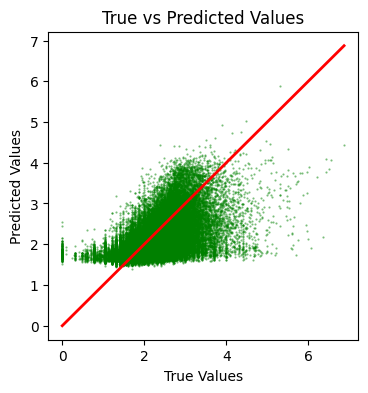

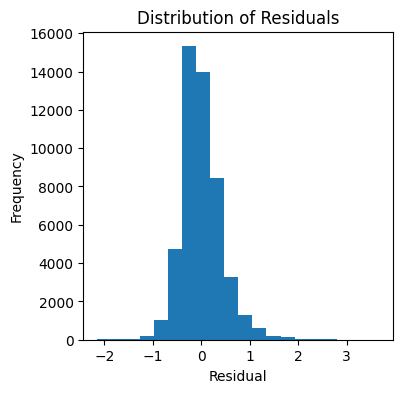

In [72]:
### Initialize df_final (for experiments, mostly)
#################################################

df_final = None  
save_all_products = True
save_figures = True
verbose = 1

### Model Fitting
#################

run = True
if run:
    folds = 5

    ## X
    # features = {"all": xcol_all, "var_1": xcol_var_1, "var_10": xcol_var_10, "var_5": xcol_var_5, \
    #             "f_stat": xcol_f_stat, "r_pearson": xcol_rpearson_mean,\
    #             "rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}

    ### List of models to be tested
    # algorithms = {"LR": linear_model.LinearRegression(), "GBR": ensemble.GradientBoostingRegressor(), \
    #             "XGBR": xgb.XGBRegressor(), "XGBRF": xgb.XGBRFRegressor(),\
    #             "DTR": tree.DecisionTreeRegressor()}

    features = {"rfecv_xgb": xcol_rfecv_xgb, "rfecv_lm": xcol_rfecv_lm}
    algorithms = {"LR": linear_model.LinearRegression()}

    model_feature_importance = {}
    model_pred = {}
    model_stats = {}
    model_evaluation = {}

    y = m_giving_logp1
    for feature_type, cols in features.items():

        if verbose==1:
            print("Sklearn: Model Fitting -- ", feature_type)
        
        X = df_preprocessed[cols]
        
        # Creating a training set index by partitioning the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
        #print("feature_type = %10s | No. of cols = %3d" %(feature_type, len(cols)))
    
        model_feature_importance[feature_type] = {}
        model_pred[feature_type] = {}
        model_stats[feature_type] = {}
        model_evaluation[feature_type] = {}
        
        globals() ["model_df_%s" %(feature_type)] = pd.DataFrame({"Features": X.keys().tolist()})
        for algo_name, model in algorithms.items():

            if verbose==2:
                print("Sklearn: Model Fitting -- ", feature_type, algo_name)
            
            ### Fitting
            scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
            results = model.fit(X_train, y_train)
            y_pred = results.predict(X_test)
        
            ### Statistics
            # Calculate MAE, MSE and RMSE
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
        
            ### Populate the dictionaries and the DataFrame

            try:
                if hasattr(model, 'feature_importances_'):
                    model_feature_importance[feature_type][algo_name] = results.feature_importances_
                elif hasattr(model, 'coef_'):
                    model_feature_importance[feature_type][algo_name] = results.coef_.flatten()
            #except AttributeError:
            #    print("%s object has no attribute feature_importances_ or coef_" %algo_name)
            except:
                pass

            model_pred[feature_type][algo_name] = y_pred
            model_stats[feature_type][algo_name] = [mae, mse, rmse]
            model_evaluation[feature_type][algo_name] = -scores.mean()
            #, X_train.shape, len(cols), model_feature_importance[feature_type][algo_name])
            
            try:
                globals() ["model_df_%s" %(feature_type)]["Coeff_%s" %algo_name] = model.coef_
            except:
                pass  
        break

    # Your list of tuples
    data = [(key, len(features[key]), key1, model_stats[key][key1][2]) for key in model_stats.keys() for key1 in model_stats[key].keys()]

    # Create a DataFrame
    df_matrix = pd.DataFrame(data, columns=["Feature_Selection", "N_Features", "Estimator", "Root_Mean_Square_Error"])
    if (save_all_products):
        df_matrix.to_csv("%s/%s_pred_mod_matrix.csv" %(subdirectory_name, client_name), index=True)

### Best Fit Model
##################
print("Fitting for the Best-Fit Model")
best_fit_idx = df_matrix.Root_Mean_Square_Error.idxmin()
best_fit_algo_name = df_matrix.iloc[best_fit_idx]["Estimator"]
best_fit_feature_type = df_matrix.iloc[best_fit_idx]["Feature_Selection"]

model = algorithms[best_fit_algo_name]
cols = features[best_fit_feature_type]
X = df_preprocessed[cols]
y = m_giving_logp1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
results = model.fit(X_train, y_train)
y_pred_train = results.predict(X_train)
y_pred_test = results.predict(X_test)
y_pred_all = results.predict(X)
y_scores = y_pred_all*(100.0/y_pred_all.max())

df_preprocessed["constituent_id"] = constituent_id
df_preprocessed["m_giving_1p"] = y
df_preprocessed["scores"] = y_scores
df_final = df_preprocessed[["constituent_id", "m_giving_1p", "scores"]].merge(df_taggers, on=["constituent_id"], how="left")
if save_all_products:
    df_final.to_csv("%s/%s_pred_mod_scores.csv" %(subdirectory_name, client_name), index=False)

### Save Figures
if save_all_products:
    with open("%s/%s_pred_mod_bestfit_results_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
        pickle.dump(results,f)
    with open("%s/%s_pred_mod_bestfit_model_%s_%s.pkl" %(subdirectory_name, client_name, best_fit_algo_name, best_fit_feature_type),"wb") as f:
        pickle.dump(model,f)


### Diagnostic Plots for the Best-Fit Model
###########################################

if save_figures:
    print("Diagnostic Plots")

    # Ground Truth vs Predicted
    colors = cm.prism(np.linspace(0, 1, len(model_pred.keys())))
    plt.figure(figsize=(4, 4))
    plt.scatter(y, y_pred_all, color='green', alpha=0.5, s=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.savefig("%s/%s_pred_mod_scatter_plot.jpg" %(subdirectory_name, client_name), bbox_inches="tight")

    # Residuals
    residuals = y_test - y_pred_test
    plt.figure(figsize=(4, 4))
    plt.hist(residuals, bins=20)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.savefig("%s/%s_pred_mod_residuals_hist.jpg" %(subdirectory_name, client_name), bbox_inches="tight")


# **Use the Best-Fitting Model for Demonstrative Plots**
**First, populate the results by running the algorithm with the optimal number of features**

In [73]:
run = True
folds = 5
if run:
    model = xgb.XGBRFRegressor()
    cols = xcol_rfecv_xgb

    X = df_preprocessed[cols]
    y = m_giving_logp1
    
    # Creating a training set index by partitioning the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    scores = cross_val_score(model, X_train, y_train, cv=folds, scoring='neg_root_mean_squared_error')
    results = model.fit(X_train, y_train)
    y_pred_train = results.predict(X_train)
    y_pred = results.predict(X_test)
    y_pred_all = results.predict(X)
    y_scores = y_pred_all*(100.0/y_pred_all.max())
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    #plt.scatter(y_obs_scores, y_scores)
                   

**True vs Predicted Values!**

Text(0.5, 1.0, 'True vs Predicted Values')

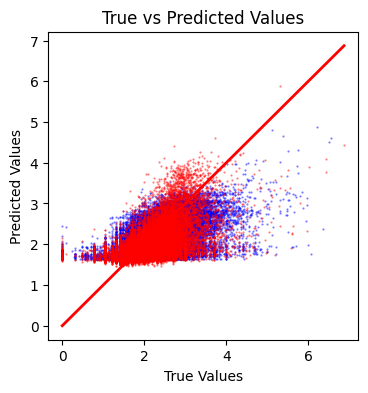

In [74]:
### Diagnostic Plots for the Best-Fit Model

plt.figure(figsize=(4, 4))
#plt.scatter(y, y_pred_all, color='green', alpha=0.5, s=0.3)
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5, s=0.3)
plt.scatter(y_test, y_pred_test, color='red', alpha=0.5, s=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

**Residuals**

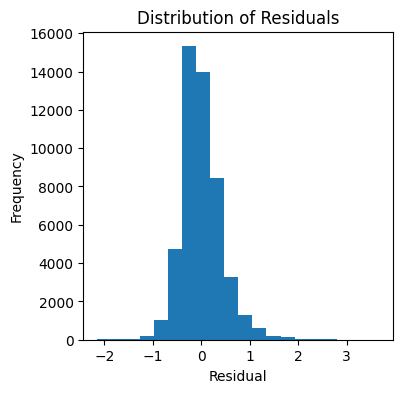

In [75]:
# Residuals
residuals = y_test - y_pred_test

plt.figure(figsize=(4, 4))
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.savefig("%s_pred_mod_residuals_hist.jpg" %client_name, bbox_inches="tight")
plt.show()

**The following mosaic of plots shows every feature against the response variable, the "total lifetime giving"**

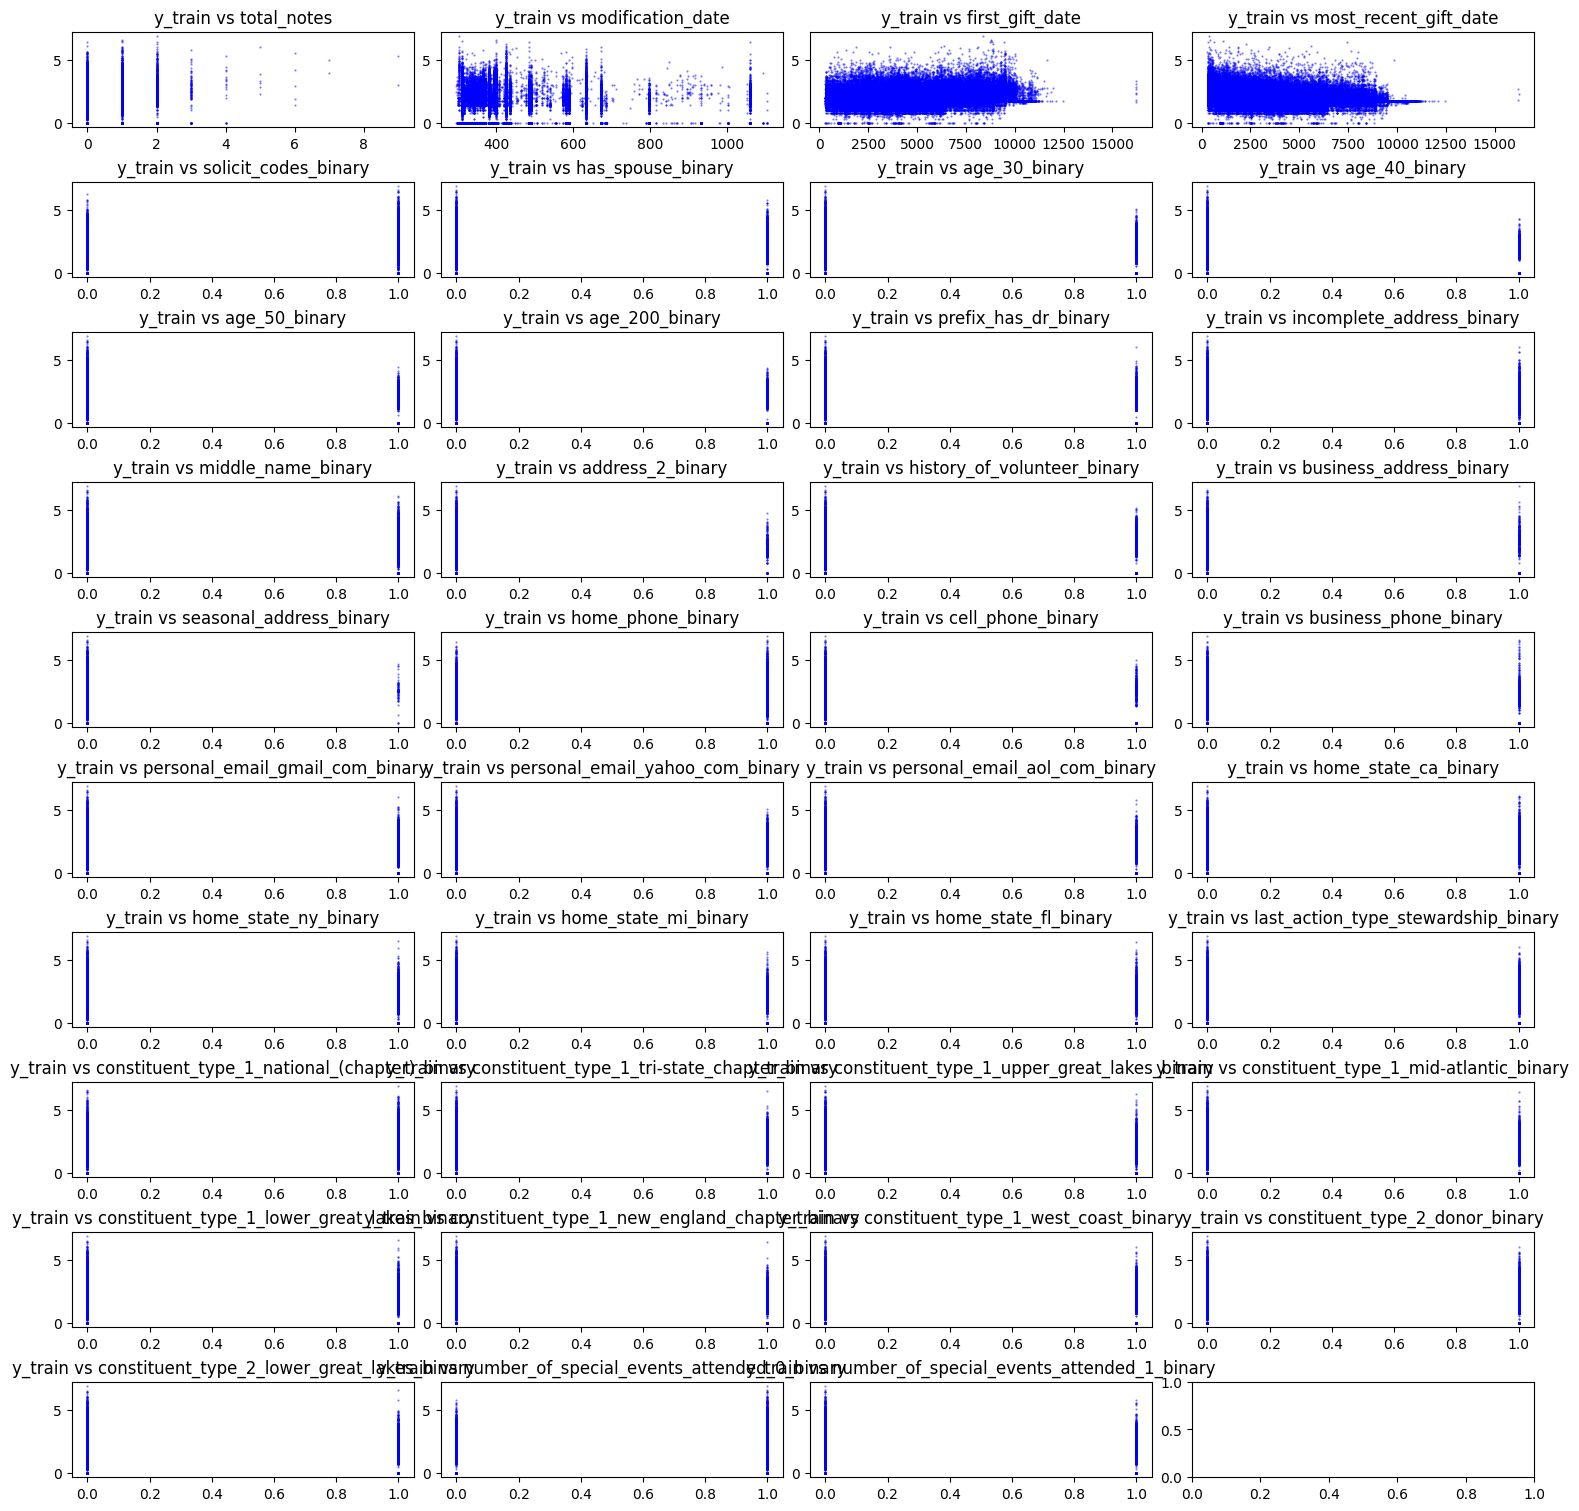

In [76]:
n = int(np.ceil(len(xcol_all)/4))
fig, axs = plt.subplots(n, 4, figsize=(15, 15), layout='constrained')

for ax, feature in zip(axs.flat, xcol_all):
    #print(ax, feature)
    #ax.figure(figsize=(4, 4))
    X = df_cd[feature]
    y = np.log(1+df_cd["lifetime_giving"])/np.log(10)
    ax.scatter(X, y, color='blue', alpha=0.5, s=0.3)
    # ax.xlabel("%s_train" %feature)
    # ax.ylabel("y_train")
    ax.set_title('y_train vs %s' %feature)